# Credit Risk Analysis --- Classification

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, f1_score, precision_score, recall_score, matthews_corrcoef
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from jcopml.tuning.space import Real, Integer
from sklearn.compose import ColumnTransformer
from yellowbrick.model_selection import LearningCurve, ValidationCurve
from jcopml.feature_importance import mean_score_decrease

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import scipy.stats as ss
from sklearn.neighbors import KernelDensity
from scipy.stats import mannwhitneyu, chi2_contingency
from scipy.stats import shapiro

import warnings
warnings.filterwarnings("ignore")

In [51]:
credit = pd.read_csv('credit_clean.csv').drop('Unnamed: 0', axis = 1)

In [52]:
credit.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk,Age Groups
0,67,male,2,own,little,little,1169,6,radio/TV,good,60+
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad,<30
2,49,male,1,own,little,little,2096,12,education,good,40-59
3,45,male,2,free,little,little,7882,42,furniture/equipment,good,40-59
4,53,male,2,free,little,little,4870,24,car,bad,40-59


# Dataset Splitting

In [53]:
X = credit.drop('Risk', axis = 1)
y = credit['Risk'].map({'good' : 1, 'bad' : 0})

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 101, stratify = y)

# Feature Selection

Seperti pada analisa di notebook eksplorasi, dapat dilihat bahwa fitur <i>Purpose</i> dan <i>Job</i> tidaklah signifikan. Itu kenapa saya tidak akan mempertimbangkan kedua fitur tersebut. 

## Correlation Analysis

In [54]:
def correlation_ratio(categories, measurement):
    fcat,_ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0, cat_num):
        cat_measures = measurement[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array, y_total_avg),2)))
    debadminator = np.sum(np.power(np.subtract(measurement,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = np.sqrt(numerator/debadminator)
    return eta

#Correlation measurement untuk data kategorikal dan kategorical
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

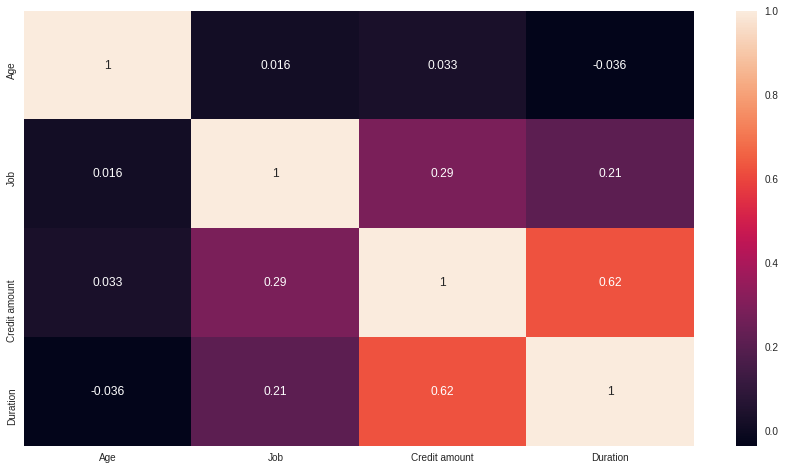

In [55]:
plt.figure(figsize = (15,8))
sns.heatmap(credit.corr(), annot = True)

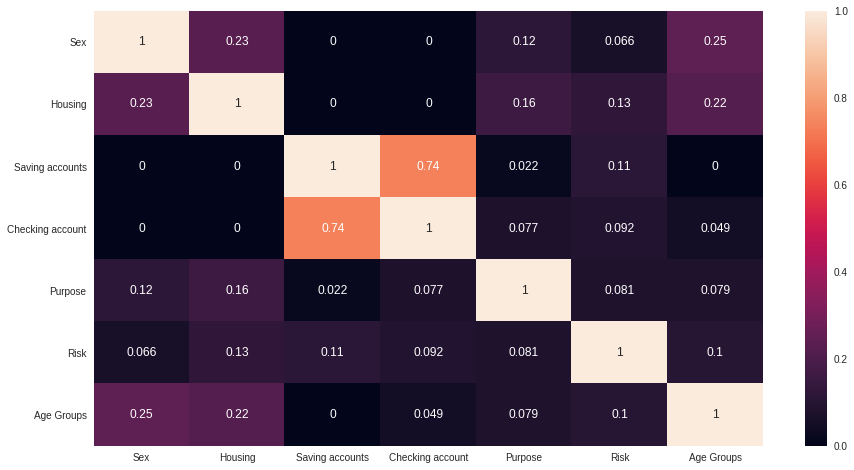

In [56]:
categorical = credit.select_dtypes('object')

corrCat = []

for i in categorical.columns:
    mat = []
    for j in categorical.columns:
        mat.append(cramers_v(credit[i],credit[j]))
    corrCat.append(mat)
    
dfcramers = pd.DataFrame(corrCat, index = categorical.columns, columns = categorical.columns)
plt.figure(figsize = (15,8))
sns.heatmap(dfcramers,annot = True)

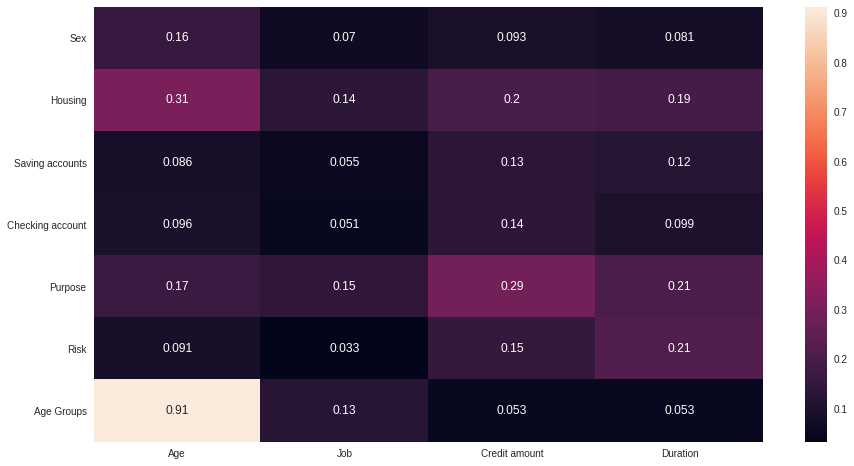

In [57]:
numerical = credit.drop(categorical, axis = 1)

corrNumCat = []

for i in categorical.columns:
    mat2 = []
    for j in numerical.columns:
        mat2.append(correlation_ratio(credit[i],credit[j]))
    corrNumCat.append(mat2)
    
dfcramers = pd.DataFrame(corrNumCat, index = categorical.columns, columns = numerical.columns)
plt.figure(figsize = (15,8))
sns.heatmap(dfcramers,annot = True)

## Mean Score Decrease

In [58]:
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('scaler', RobustScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, ['Age','Credit amount', 'Duration']),
        ('cat', categorical_transformer, ['Sex','Housing','Saving accounts', 'Checking account', 'Age Groups'])
    ]
)

In [59]:
xgb_params = {
    'xgb__max_depth': Integer(low=2, high=10),
    'xgb__learning_rate': Real(low=-2, high=0, prior='log-uniform'),
    'xgb__n_estimators': Integer(low=150, high= 250),
    'xgb__subsample': Real(low=0.4, high=0.8, prior='uniform'),
    'xgb__gamma': Integer(low=1, high=9),
    'xgb__colsample_bytree': Real(low=0.1, high=1, prior='uniform'),
    'xgb__reg_alpha': Real(low=-2, high=1, prior='log-uniform'),
    'xgb__reg_lambda': Real(low=-2, high=1, prior='log-uniform')
}

In [60]:
xgb = Pipeline(steps=[('preprocessor', preprocessor),
                      ('xgb', XGBClassifier(random_state = 101))])

xgb_random = RandomizedSearchCV(estimator=xgb,param_distributions=xgb_params, scoring='f1', cv = 3
                                  ,random_state = 101)

xgb_random.fit(X_train, y_train)
print(xgb_random.best_params_)
print(xgb_random.score(X_train, y_train), xgb_random.score(X_test, y_test))

{'xgb__colsample_bytree': 0.9218382019081918, 'xgb__gamma': 5, 'xgb__learning_rate': 0.02813828423365405, 'xgb__max_depth': 9, 'xgb__n_estimators': 165, 'xgb__reg_alpha': 0.10737291253238487, 'xgb__reg_lambda': 3.9382152444172753, 'xgb__subsample': 0.7321110848795189}
0.8350824587706147 0.8203592814371258


,feature,importance,stdev
7,Duration,0.015546,0.002308
4,Saving accounts,0.005030,0.001456
0,Age,0.004244,0.000923
3,Housing,0.004136,0.001142
9,Age Groups,0.003292,0.001190
6,Credit amount,0.000972,0.001605
5,Checking account,0.000720,0.001429
1,Sex,0.000128,0.000306
2,Job,0.000000,0.000000
8,Purpose,0.000000,0.000000


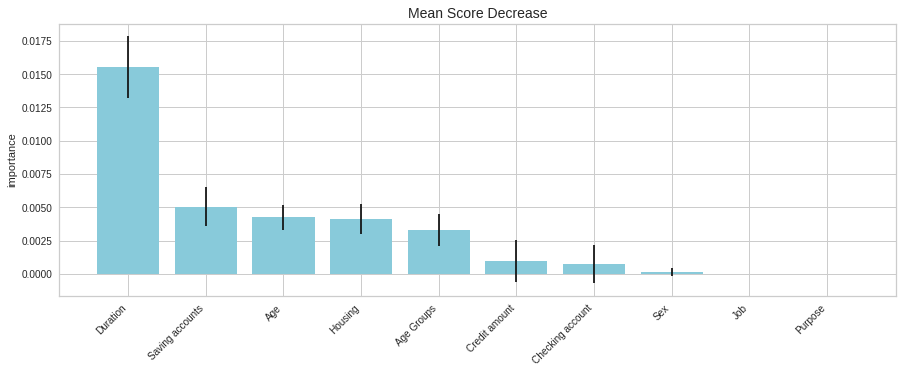

In [61]:
mean_score_decrease(X_train, y_train, xgb_random, plot = True, random_state = 101)

> Sebetulnya keduanya metode setuju, bahwa fitur-fitur ini tidak terlalu punya korelasi yang kuat dengan target. 

# Modeling

In [62]:
def evaluationMetrics(y_test, y_pred):
    f1.append(f1_score(y_test,y_pred))
    prec.append(precision_score(y_test, y_pred))
    recall.append(recall_score(y_test, y_pred))
    auc.append(roc_auc_score(y_test, y_pred))
    matthews.append(matthews_corrcoef(y_test, y_pred))

In [63]:
metric = pd.DataFrame(index = ['XGBoost Classifier', 'Random Forest Classifier']) 
f1 = []
prec = []
recall = []
matthews = []
auc = []

In [64]:
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('scaler', RobustScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, ['Age','Credit amount', 'Duration']),
        ('cat', categorical_transformer, ['Sex','Housing','Saving accounts', 'Checking account', 'Age Groups'])
    ]
)

## XGB Classifier

In [65]:
xgb_params = {
    'xgb__max_depth': Integer(low=2, high=10),
    'xgb__learning_rate': Real(low=-2, high=0, prior='log-uniform'),
    'xgb__n_estimators': Integer(low=150, high= 250),
    'xgb__subsample': Real(low=0.4, high=0.8, prior='uniform'),
    'xgb__gamma': Integer(low=1, high=9),
    'xgb__colsample_bytree': Real(low=0.1, high=1, prior='uniform'),
    'xgb__reg_alpha': Real(low=-2, high=1, prior='log-uniform'),
    'xgb__reg_lambda': Real(low=-2, high=1, prior='log-uniform')
}

In [66]:
xgb = Pipeline(steps=[('preprocessor', preprocessor),
                      ('xgb', XGBClassifier(random_state = 101))])

xgb_random = RandomizedSearchCV(estimator=xgb,param_distributions=xgb_params, scoring='f1', cv = 3
                                  ,random_state = 101)

xgb_random.fit(X_train, y_train)
print(xgb_random.best_params_)
print(xgb_random.score(X_train, y_train), xgb_random.score(X_test, y_test))

{'xgb__colsample_bytree': 0.9218382019081918, 'xgb__gamma': 5, 'xgb__learning_rate': 0.02813828423365405, 'xgb__max_depth': 9, 'xgb__n_estimators': 165, 'xgb__reg_alpha': 0.10737291253238487, 'xgb__reg_lambda': 3.9382152444172753, 'xgb__subsample': 0.7321110848795189}
0.8350824587706147 0.8203592814371258


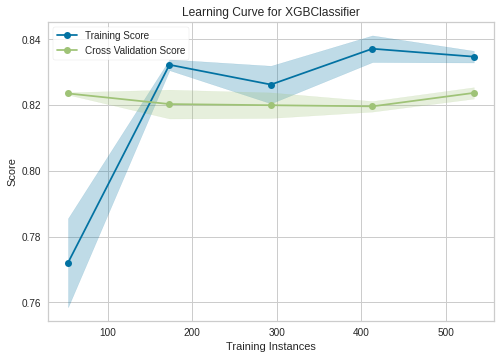

In [67]:
sizes = np.linspace(0.3, 1, 10)

visualizer = LearningCurve(
    xgb_random.best_estimator_, scoring = 'f1', train_size = sizes, random_state = 101,  cv = 3
)

visualizer.fit(X_train, y_train)
visualizer.show()

> Menarik, learning curve memperlihatkan validation test cukup konsisten di atas. Saya pikir ini memang sedikit overfitting, namun masih dapat ditoleransi.

In [68]:
y_pred_xgb = xgb_random.best_estimator_.predict(X_test)
evaluationMetrics(y_test, y_pred_xgb)

In [69]:
confusion_matrix(y_test, y_pred_xgb)

array([[  3,  57],
       [  3, 137]])

In [70]:
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.50      0.05      0.09        60
           1       0.71      0.98      0.82       140

    accuracy                           0.70       200
   macro avg       0.60      0.51      0.46       200
weighted avg       0.64      0.70      0.60       200



## Random Forest Classifier

In [71]:
rfc_params = {
    'rfc__n_estimators': Integer(low=150, high=250),
    'rfc__max_depth': Integer(low=10, high=40),
    'rfc__max_features': Real(low=0.1, high=1, prior='uniform'),
    'rfc__min_samples_leaf': Integer(low=1, high=18)
}

In [72]:
rfc = Pipeline(steps=[('preprocessor', preprocessor),
                      ('rfc', RandomForestClassifier(random_state = 101))])

rfc_random = RandomizedSearchCV(estimator = rfc, param_distributions = rfc_params, 
                                scoring='f1', cv = 5,random_state = 101)

rfc_random.fit(X_train, y_train)
print(rfc_random.best_params_)
print(rfc_random.score(X_train, y_train), rfc_random.score(X_test, y_test))

{'rfc__max_depth': 23, 'rfc__max_features': 0.36040806454620955, 'rfc__min_samples_leaf': 9, 'rfc__n_estimators': 210}
0.8485780169100692 0.834355828220859


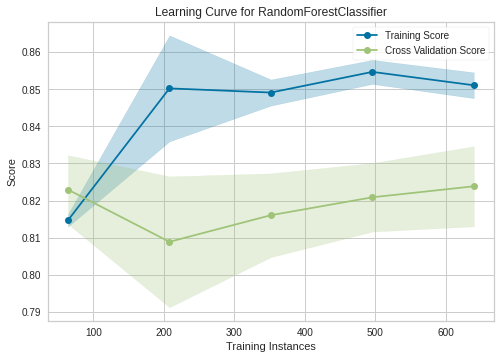

In [73]:
sizes = np.linspace(0.3, 1, 10)

visualizer = LearningCurve(
    rfc_random.best_estimator_, scoring = 'f1', train_size = sizes, random_state = 101,  cv = 5
)

visualizer.fit(X_train, y_train)
visualizer.show()

> Random forest mengalami overfitting.

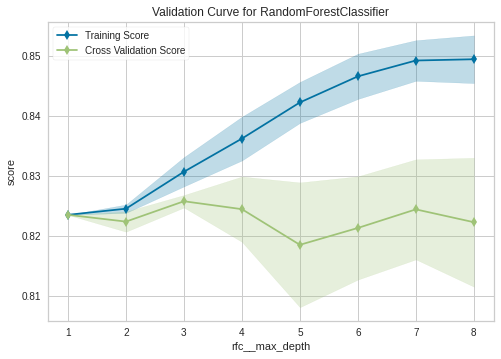

In [74]:
viz = ValidationCurve(
    rfc_random.best_estimator_, param_name="rfc__max_depth",
    param_range=np.arange(1, 9), cv=5, scoring="f1"
)

# Fit and show the visualizer
viz.fit(X_train, y_train)
viz.show()

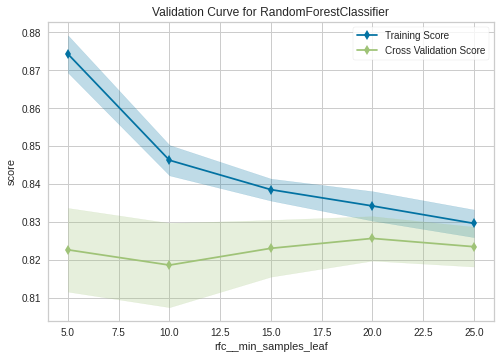

In [75]:
viz = ValidationCurve(
    rfc_random.best_estimator_, param_name="rfc__min_samples_leaf",
    param_range=np.arange(0, 30, 5), cv=5, scoring="f1"
)

# Fit and show the visualizer
viz.fit(X_train, y_train)
viz.show()

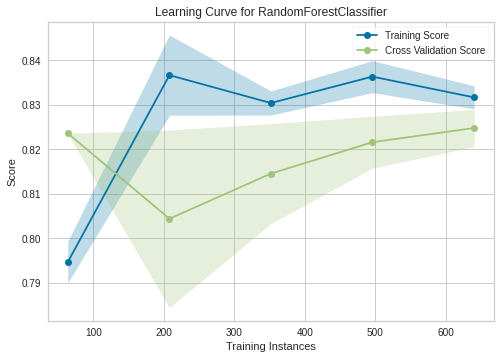

In [76]:
rfc_tuned = Pipeline(steps=[('preprocessor', preprocessor),
                      ('rfc', RandomForestClassifier(random_state = 101, n_estimators = 300,
                                                   max_features = 0.8, min_samples_leaf = 25, 
                                                     max_depth = 3))])

rfc_tuned.fit(X_train, y_train)

sizes = np.linspace(0.3, 1, 10)
visualizer = LearningCurve(
    rfc_tuned, scoring = 'f1', train_size = sizes, random_state = 101,  cv = 5
)

visualizer.fit(X_train, y_train)
visualizer.show()

> Saya pikir, saya akan berhenti di hyperparameter ini. Model masih mengalami overfitting, seharusnya dapat lebih baik lagi. 

In [77]:
y_pred_rfc = rfc_tuned.predict(X_test)
evaluationMetrics(y_test, y_pred_rfc)

In [78]:
confusion_matrix(y_test, y_pred_rfc)

array([[  3,  57],
       [  1, 139]])

In [79]:
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.50      0.05      0.09        60
           1       0.71      0.98      0.82       140

    accuracy                           0.70       200
   macro avg       0.60      0.51      0.46       200
weighted avg       0.64      0.70      0.60       200



In [80]:
metric['F1'] = f1
metric['recall'] = recall
metric['precision'] = prec
metric['AUC'] = auc
metric['MCC'] = matthews

In [81]:
metric

,F1,recall,precision,AUC,MCC
XGBoost Classifier,0.820359,0.978571,0.706186,0.514286,0.076753
Random Forest Classifier,0.827381,0.992857,0.709184,0.521429,0.140283


# Conclusion

Pada perbandingan antara XGBoost Classisfier dan Random Forest Classifier, random forest memiliki AUC-Score lebih baik dari XGBoost. Namun sayangnya keduanya memiliki MCC yang bisa dibilang kecil, hampir menuju 0. Dan keduanya punya recall yang tinggi. Yang artinya kedua model, punya True Positive (TP) yang tinggi atau dalam dataset ini, punya kemampuan yang sangat baik menebak dengan benar orang-orang yang beresiko.  